# infrastructure-attributes

The procedure of constructing infrastructure attributes for supernodes. Here we also additionally process these attributes into infrastructure features.

Requires:
1. `data/preprocessed/infrastructure.json`
2. `data/supernodes/supernodes.json`

Produces:
1. `data/supernodes/supernode_attributes.json`
2. `data/features/infrastructure_features.json`

In [1]:
import sys
sys.path.append('..')

In [2]:
from itertools import chain, product

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from matplotlib import pyplot as plt

from myutils.spatial import get_earth_distances
from myutils.stats import corrcoef
from myutils.json import save_json

from config import infrastructure_fpath, supernodes_fpath, supernode_attributes_fpath,\
    infrastructure_features_fpath

In [3]:
supernodes = pd.read_json(supernodes_fpath).set_index('id')

supernodes.head(2)

,stops,diameter,types,lat,lon
id,,,,,
0,"[29058, 15366, 1687, 1688, 15385, 2080, 2081, ...",0.732963,"[bus, trolley, tram, subway]",59.85171,30.322415
1,"[18, 18077, 18078, 32036, 16177, 16050, 27063,...",0.909368,"[bus, tram, trolley, subway]",59.95021,30.287937


In [4]:
infrastructure = pd.read_json(infrastructure_fpath)

infrastructure.head(2)

,id,lat,lon,types,name,diameter
0,267959524,59.661098,30.785173,[tourism],Саблинский водопад,0.0
1,268911313,59.688758,29.920383,[car_related],Киришиавтосервис 13,0.0


In [5]:
infrastructure_type_counts = pd.Series(chain.from_iterable(infrastructure['types'])).value_counts()

infrastructure_types = infrastructure_type_counts.index.tolist()

infrastructure_type_counts.head()

residential    30946
shop           15925
restaurant      8335
service         4634
medicine        4454
dtype: int64

In [6]:
infrastructure_coords = infrastructure[['lat', 'lon']].values
supernode_coords = supernodes[['lat', 'lon']].values

supernode_diameters = supernodes['diameter'].values

In [7]:
supernode_attributes = pd.DataFrame(index=supernodes.index, columns=infrastructure_types).fillna(0)

window = 0.2

dmins = []

for i, coords in enumerate(tqdm(infrastructure_coords)):
    obj = infrastructure.iloc[i]
    obj_types = obj['types']
    obj_diameter = obj['diameter']
    
    distances = get_earth_distances(coords.reshape(1, -1), supernode_coords).flatten()\
        - supernode_diameters / 2 - obj_diameter / 2
    distances[distances < 0] = 0
    
    dmin = distances.min()
    dmins.append(dmin)
    
    if dmin >= 1:
        continue
    
    dmax = dmin + window

    close_supernodes = supernodes.index[np.where(distances <= dmax)[0]]
    
    for s, t in product(close_supernodes, obj_types):
        supernode_attributes.loc[s, t] += 1
        
dmins = np.array(dmins)
        
supernode_attributes = supernode_attributes.reset_index()

supernode_attributes.head(2)

100%|██████████| 89563/89563 [01:09<00:00, 1281.58it/s]


,id,residential,shop,restaurant,service,medicine,education_research,tourism,sport,car_related,...,administrative,supermarket,hotel_business,industrial,bank_and_money,printing_and_books,post_office,religion,business_center_or_mall_or_marketplace,theatre_cinema
0,0,141,149,74,43,46,21,14,33,5,...,8,13,3,2,27,13,4,0,0,0
1,1,111,114,108,42,51,33,41,13,6,...,18,6,13,6,7,9,4,7,1,0


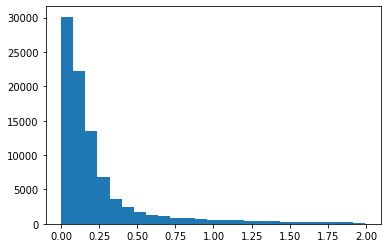

In [8]:
plt.hist(dmins, bins=25);

In [9]:
supernode_attributes_json = [row.to_dict() for _, row in supernode_attributes.iterrows()]

len(supernode_attributes_json)

3202

In [10]:
save_json(supernode_attributes_json, supernode_attributes_fpath)

## Infrastructure features

In [11]:
infrastructure_features = pd.read_json(supernode_attributes_fpath).set_index('id')

infrastructure_features.head(2)

,residential,shop,restaurant,service,medicine,education_research,tourism,sport,car_related,company,administrative,supermarket,hotel_business,industrial,bank_and_money,printing_and_books,post_office,religion,business_center_or_mall_or_marketplace,theatre_cinema
id,,,,,,,,,,,,,,,,,,,,
0,141,149,74,43,46,21,14,33,5,5,8,13,3,2,27,13,4,0,0,0
1,111,114,108,42,51,33,41,13,6,9,18,6,13,6,7,9,4,7,1,0


In [12]:
total = infrastructure_features.sum(axis=1)

mask = (total > 0)
infrastructure_features[mask] = infrastructure_features[mask].divide(total[mask], axis=0)
infrastructure_features['total'] = total

# infrastructure_features['total'] = np.log(1 + infrastructure_features['total'])

infrastructure_features.head(2)

,residential,shop,restaurant,service,medicine,education_research,tourism,sport,car_related,company,...,supermarket,hotel_business,industrial,bank_and_money,printing_and_books,post_office,religion,business_center_or_mall_or_marketplace,theatre_cinema,total
id,,,,,,,,,,,,,,,,,,,,,
0,0.234609,0.247920,0.123128,0.071547,0.076539,0.034942,0.023295,0.054908,0.008319,0.008319,...,0.021631,0.004992,0.003328,0.044925,0.021631,0.006656,0.000000,0.000000,0.0,601
1,0.185309,0.190317,0.180301,0.070117,0.085142,0.055092,0.068447,0.021703,0.010017,0.015025,...,0.010017,0.021703,0.010017,0.011686,0.015025,0.006678,0.011686,0.001669,0.0,599


/mnt/ess_storage/DL_0/lake/ylytkin/Development/.venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


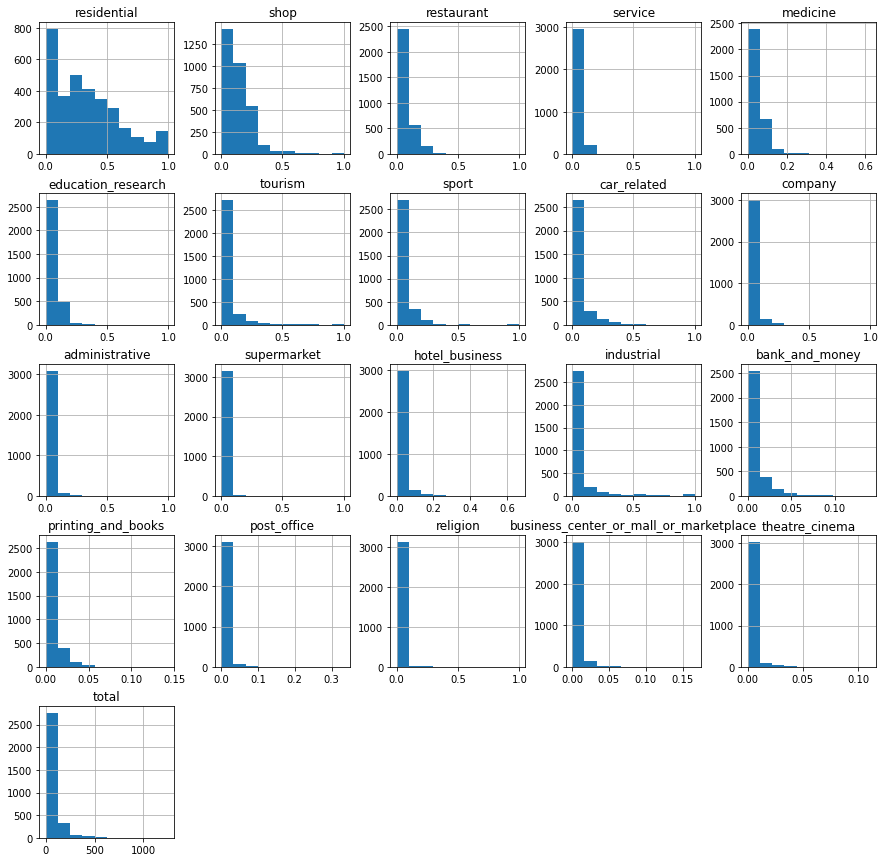

In [13]:
infrastructure_features.hist(figsize=(15, 15));

<AxesSubplot:>

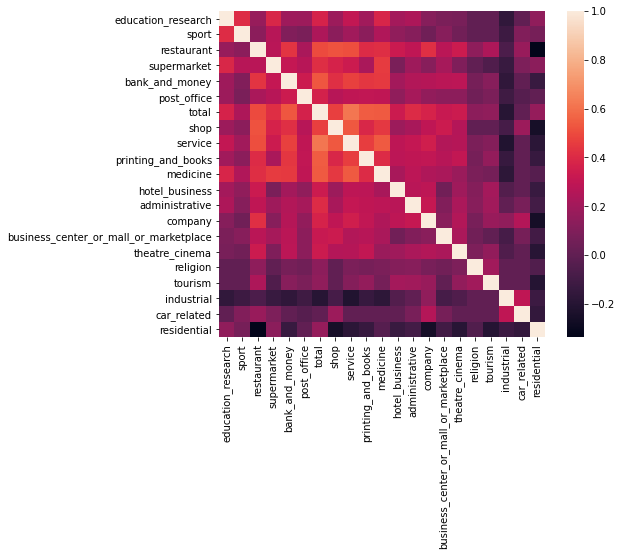

In [14]:
plt.figure(figsize=(8, 6))

sns.heatmap(corrcoef(infrastructure_features, method='spearman').fillna(0), square=True)

In [15]:
total = infrastructure_features['total']

total.head(2)

id
0    601
1    599
Name: total, dtype: int64

In [16]:
quantiles = total.quantile([0, 0.3, 0.5, 0.8, 1])
quantiles

0.0       0.0
0.3      25.0
0.5      48.0
0.8     103.0
1.0    1254.0
Name: total, dtype: float64

In [17]:
def assign_size_cluster(value: float) -> str:
    for i, q in enumerate(quantiles):
        if value <= q:
            return i

size_clusters = total.apply(assign_size_cluster)

size_clusters.head(2)

id
0    4
1    4
Name: total, dtype: int64

In [18]:
coords = supernodes[['lon', 'lat']].values

coords

array([[30.3224152 , 59.85170995],
       [30.28793738, 59.95020979],
       [30.35401882, 59.95671589],
       ...,
       [30.3595223 , 59.9445053 ],
       [30.2344264 , 59.94853172],
       [30.21190075, 59.97198015]])

Text(0.5, 1.0, 'Nodes with different number of attached infrastructure objects')

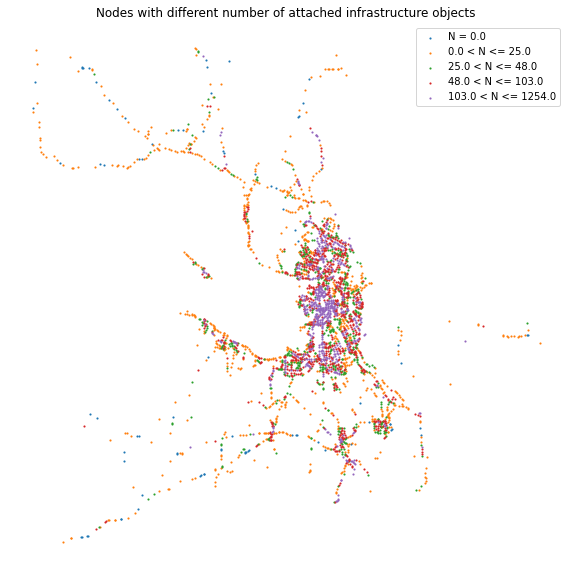

In [19]:
plt.figure(figsize=(10, 10))
plt.axis('off')

for i in sorted(size_clusters.unique()):
    cluster_coords = coords[size_clusters == i]
    
    if i == 0:
        label = f'N = {quantiles.iloc[i]}'
    else:
        label = f'{quantiles.iloc[i - 1]} < N <= {quantiles.iloc[i]}'
        
    plt.scatter(*cluster_coords.T, color=f'C{i}', marker='.', s=5, label=label)

plt.legend()
plt.title('Nodes with different number of attached infrastructure objects')

In [20]:
infrastructure_features_json = []

for _, row in infrastructure_features.reset_index().iterrows():
    row = row.to_dict()
    row['id'] = int(row['id'])
    infrastructure_features_json.append(row)

In [21]:
save_json(infrastructure_features_json, infrastructure_features_fpath)